In [1]:
################################################
# Random Forests, GBM, XGBoost, LightGBM, CatBoost
################################################

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



pd.set_option('display.max_columns', None) # bütün sütunları göster
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_csv("C:\\Users\\Monster\\Desktop\\dataa\\csv_files\\diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

#### Random Forests Algorithm:

In [3]:
rf_model = RandomForestClassifier(random_state=17) # model nesnesi oluşturuyoruz
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [4]:
# hiperparametre optimizasyonu öncesindeki hataları inceleyelim
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.753896103896104

In [5]:
cv_results['test_f1'].mean()

0.6190701534636385

In [6]:
cv_results['test_roc_auc'].mean()

0.8233960113960114

In [7]:
# hyperparameter seti(öntanımlı değerlerin de bu listelerde bulunması lazım)
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}


# en iyi parametreleri bulmak için hyperparameter setini kullanarak model üstünde gez, 5 katlı cross-validation yap
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [8]:
# GridSearchCV ile model için en iyi parametreleri bulduk
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [9]:
# en iyi parametreleri modele entegre edelim
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [10]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.766848940533151

In [11]:
cv_results['test_f1'].mean()

0.6447777811143756

In [12]:
cv_results['test_roc_auc'].mean()

0.8271054131054132

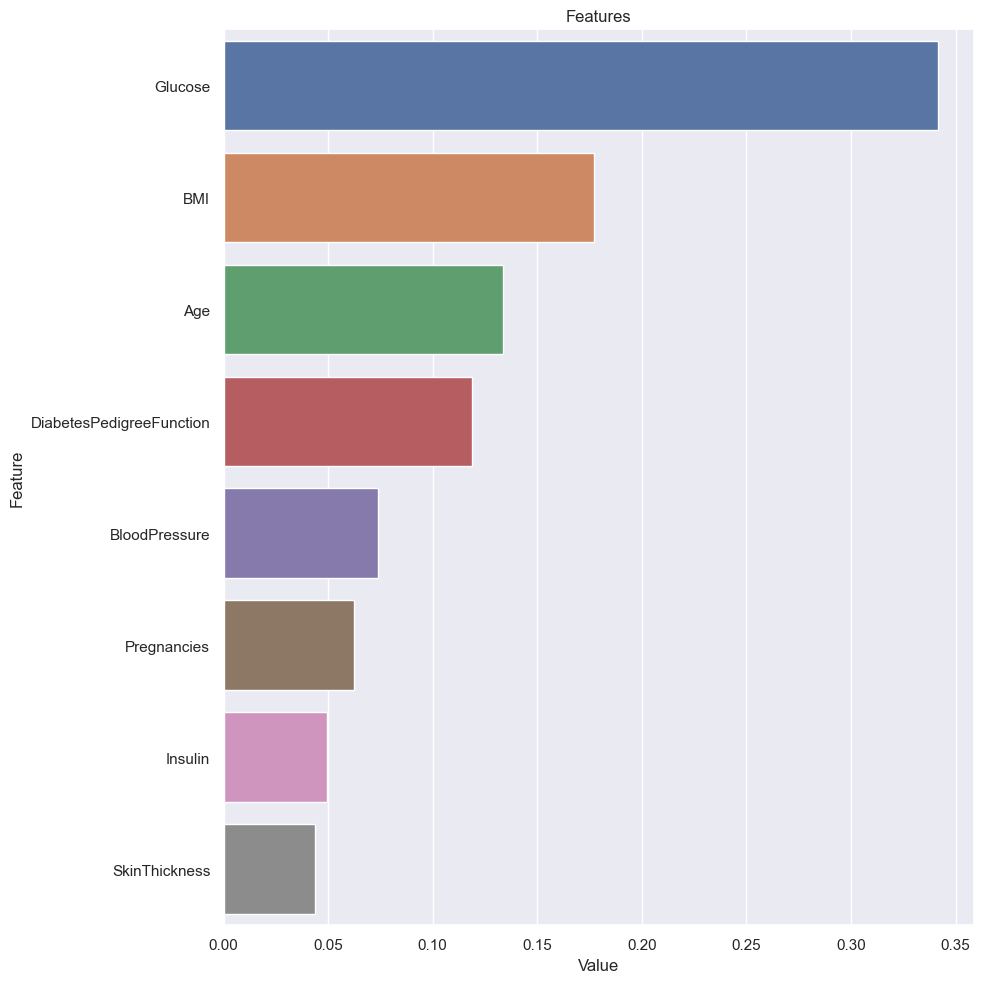

In [13]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

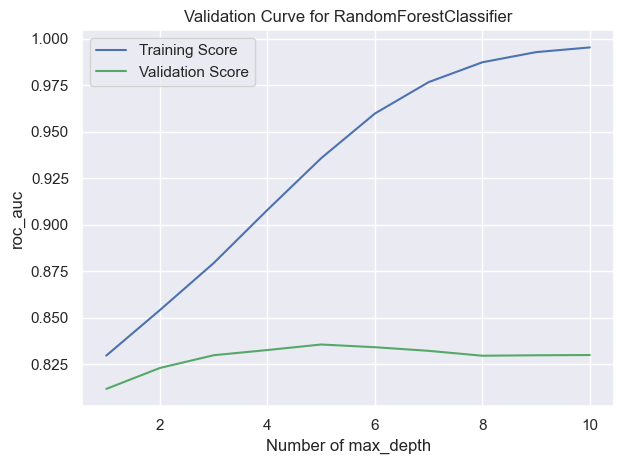

In [14]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

#### GBM(Gradient Boosting Machines) Algorithm:

In [43]:
gbm_model = GradientBoostingClassifier(random_state=17) # GBM model nesnesi oluştur

gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [44]:
# hiperparametre optimizasyonu yapmadan önceki skorları inceleyelim
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7591715474068416

In [45]:
cv_results['test_f1'].mean()

0.634235802826363

In [46]:
cv_results['test_roc_auc'].mean()

0.8254867225716283

In [47]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [48]:
gbm_best_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}

In [49]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [50]:
cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7800186741363212

In [51]:
cv_results['test_f1'].mean()

0.668605747317776

In [52]:
cv_results['test_roc_auc'].mean()

0.8257784765897973

#### XGBoost(eXtreme Gradient Boosting) Algorithm:

In [53]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [54]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7409557762498938

In [55]:
cv_results['test_f1'].mean()

0.6180796532975465

In [56]:
cv_results['test_roc_auc'].mean()

0.7934919636617749

In [57]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [58]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [59]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [60]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7630846277905101

In [61]:
cv_results['test_f1'].mean()

0.6328122330962486

In [62]:
cv_results['test_roc_auc'].mean()

0.8168742138364781

#### LightGBM Algorithm:

In [15]:
lgbm_model = LGBMClassifier(random_state=17, verbose=-1)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [16]:
cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [17]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7474492827434004
0.624110522144179
0.7990293501048218


In [18]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [19]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}

In [23]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [24]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7643578643578645
0.6372062920577772
0.8147491264849755


In [25]:
# Hiperparametre optimizasyonu yeni değerlerle
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [26]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'n_estimators': 200}

In [27]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [28]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7643833290892115
0.6193071162618689
0.8227931516422082


- LGBM'in en önemli parametresi *n_estimators*'dır. Yani tahmin sayısı daha doğrusu iterasyon sayısıdır.
- Bu sebeple ilk önce learning_rate ve colsample_bytree'nin optimum parametreleri hiperparametre optimizasyonu ile belirlernir, daha sonra diğer iki parametreyi sabit tutarak sadece n_estimators için optimizasyon yapılır.

In [29]:
# Hiperparametre optimizasyonu sadece n_estimators için.
# önceki adımlarda zaten optimum parametreleri bulduk, diğer parametreleri sabit tutarak sadece n_estimators için optimizasyon yapılır
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [30]:
lgbm_best_grid.best_params_

{'n_estimators': 200}

In [31]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [32]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7643833290892115
0.6193071162618689
0.8227931516422082


#### CatBoost Algorithm:

In [39]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

# Perform cross-validation with default parameters
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

# Print initial cross-validation results
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7735251676428148
0.6502723851348231
0.8378923829489867


In [40]:
# Define hyperparameter grid
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

# Get the best parameters
print("Best Parameters:", catboost_best_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.01}


In [41]:
# Create a new model with the best parameters
catboost_final = CatBoostClassifier(**catboost_best_grid.best_params_, random_state=17, verbose=False)

# Train the final model
catboost_final.fit(X, y)

# Perform cross-validation with the tuned model
cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

# Print final cross-validation results
print("Tuned Accuracy:", cv_results['test_accuracy'].mean())
print("Tuned F1 Score:", cv_results['test_f1'].mean())
print("Tuned ROC AUC:", cv_results['test_roc_auc'].mean())

Tuned Accuracy: 0.7721755368814192
Tuned F1 Score: 0.6322580676028952
Tuned ROC AUC: 0.842001397624039


#### Feature Importance:

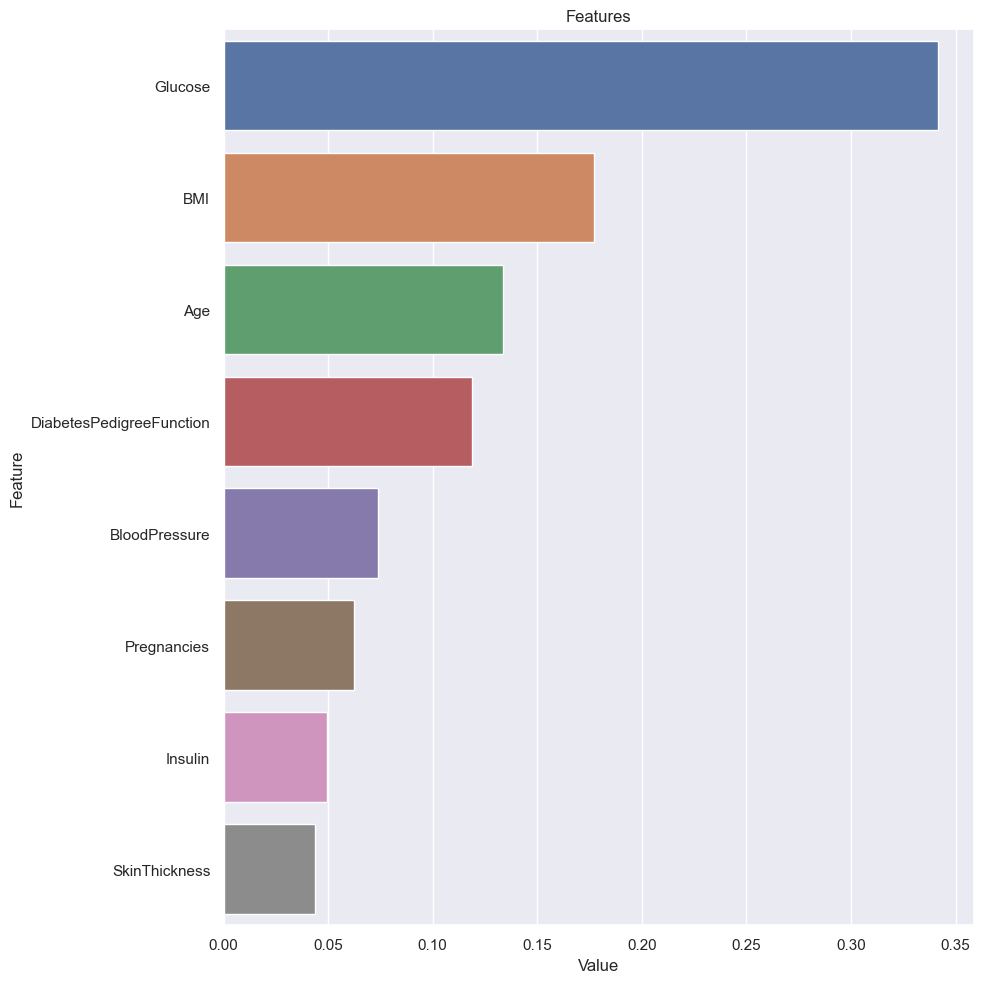

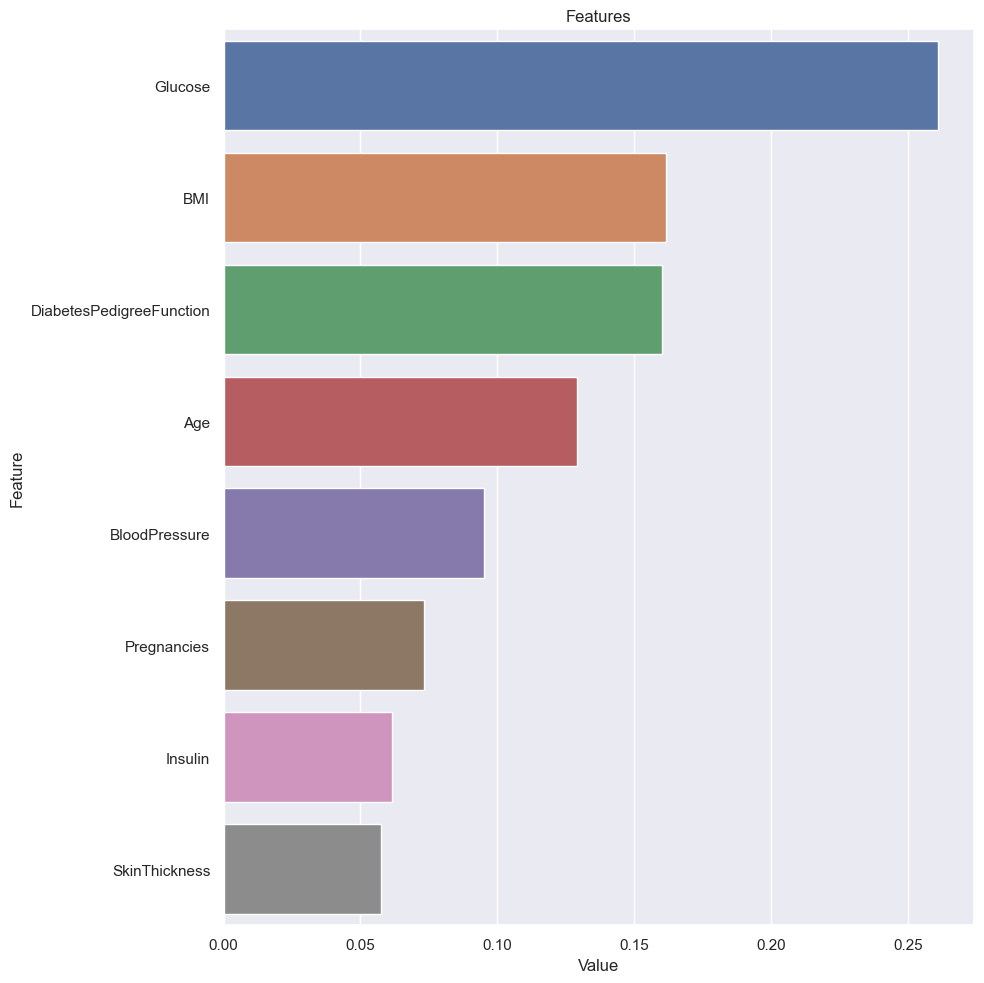

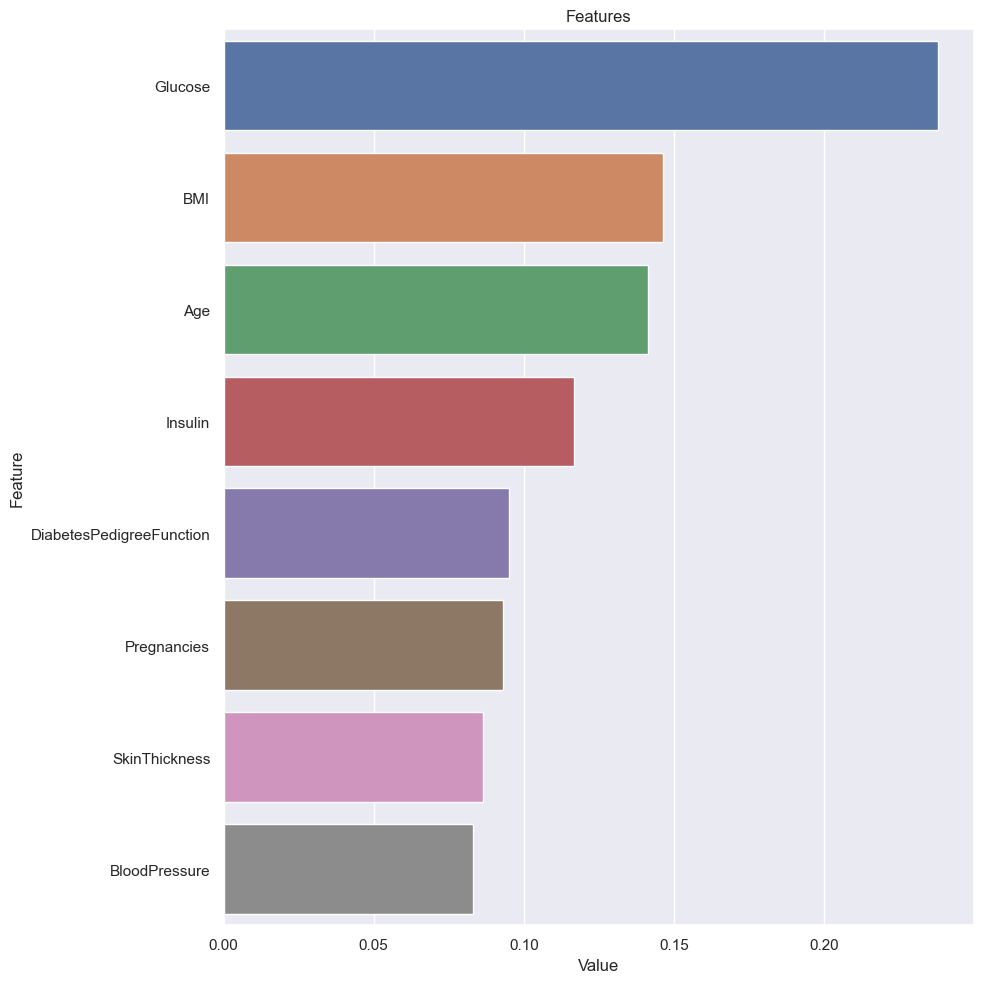

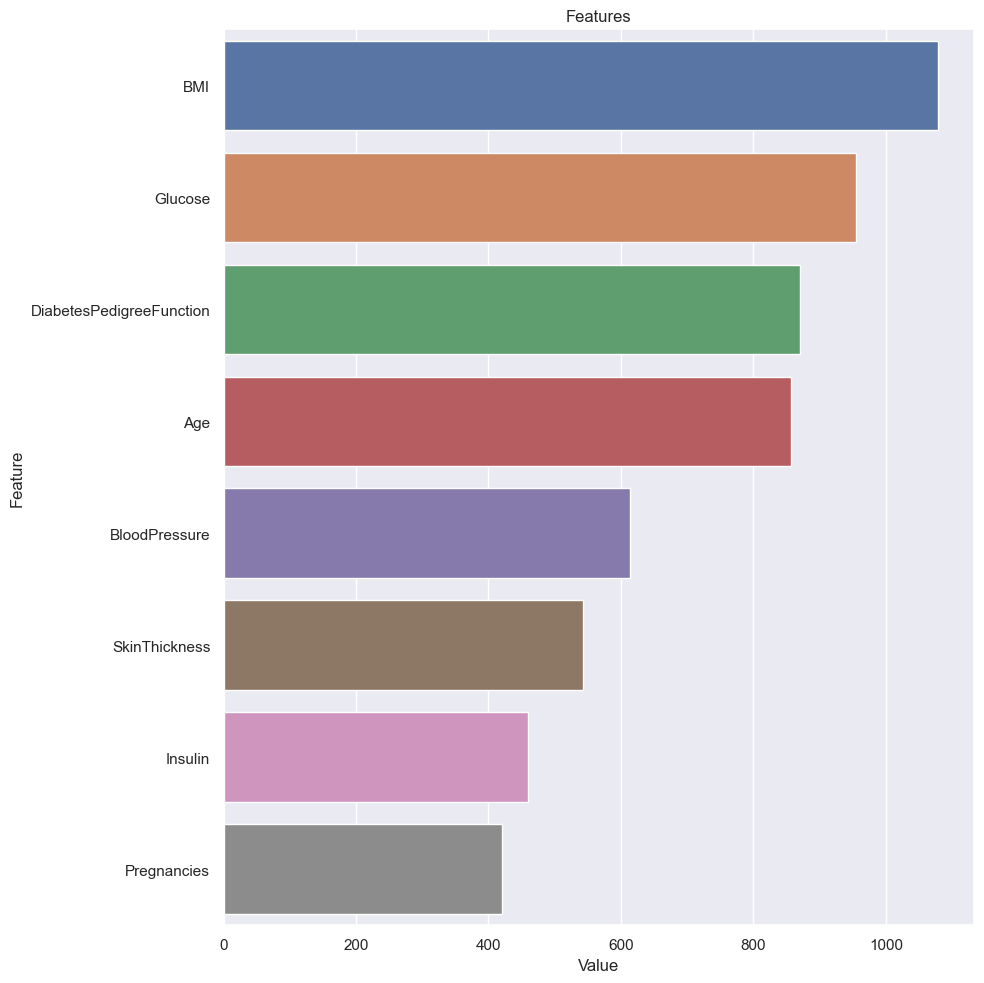

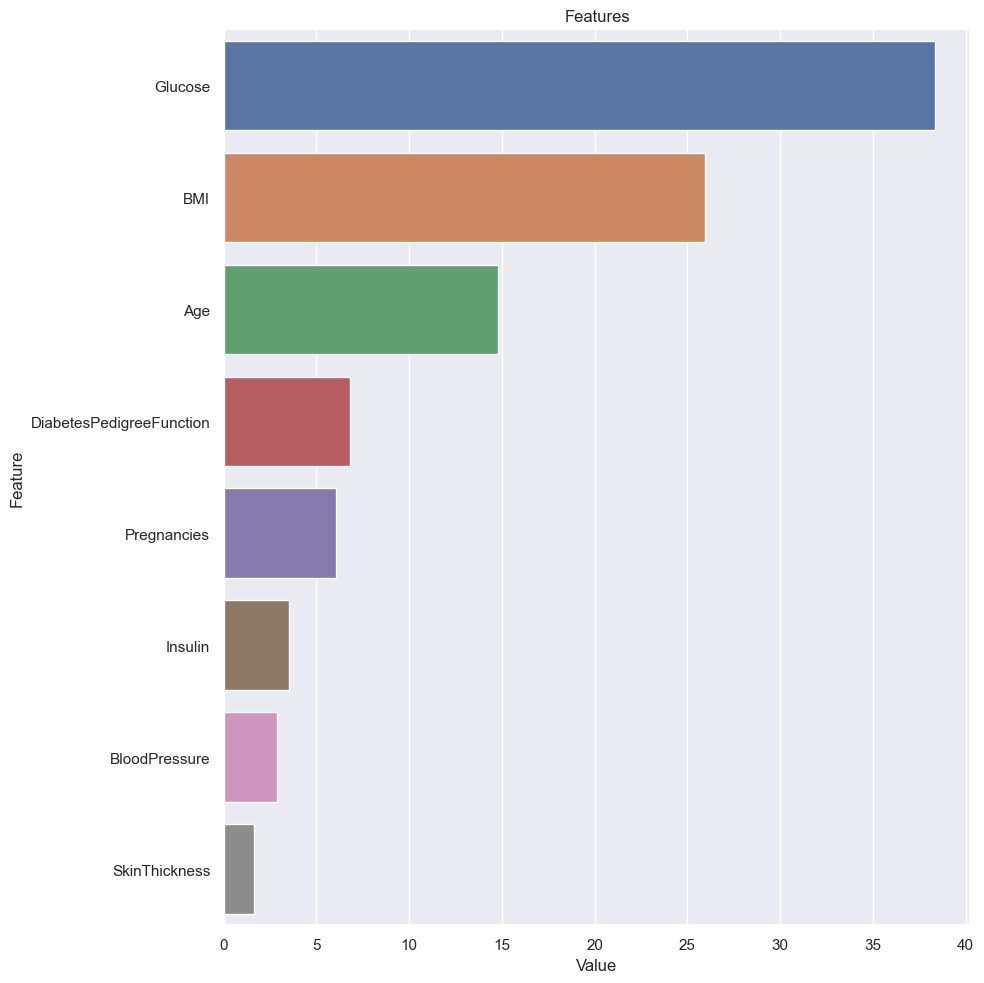

In [63]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(xgboost_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)

#### Hyperparameter Optimization with RandomSearchCV:

- GridSearchCV verilen bir setin olası bütün kombinasyonlarını tek tek dener, RandomSearchCV ise verilecek bir hiperparametre seti içerisinden rastgele seçimler yapar ve bu rastgele seçimleri arar. 

In [64]:
rf_model = RandomForestClassifier(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X, y)


rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 777,
 'min_samples_split': 44,
 'max_features': 'auto',
 'max_depth': 29}

In [65]:
rf_random_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_random_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7643748408454292
0.6133474067503558
0.8369867225716284


#### Analyzing Model Complexity with Learning Curves:

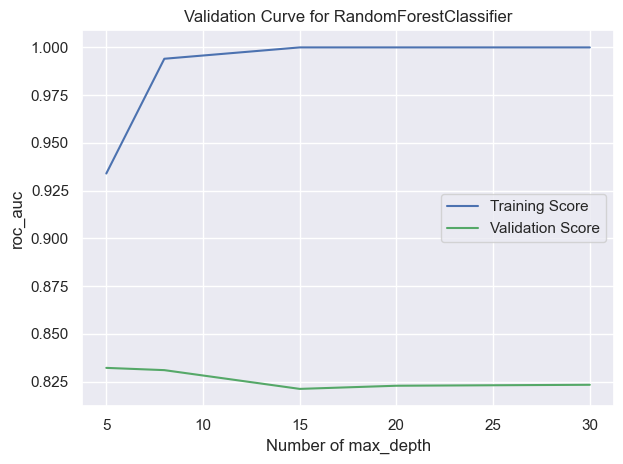

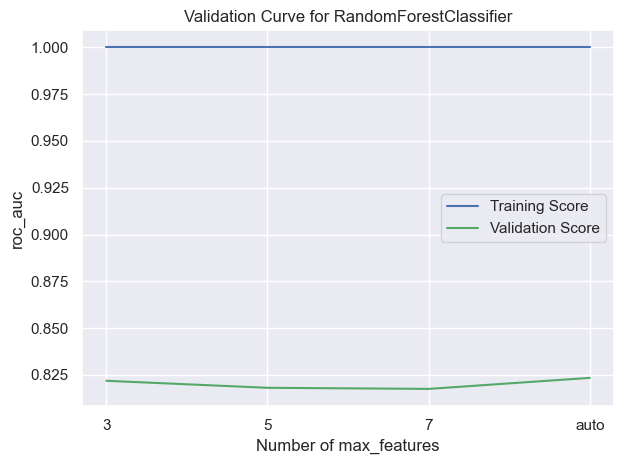

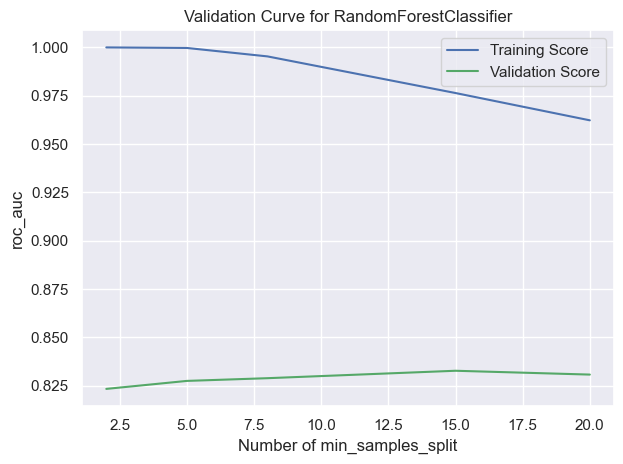

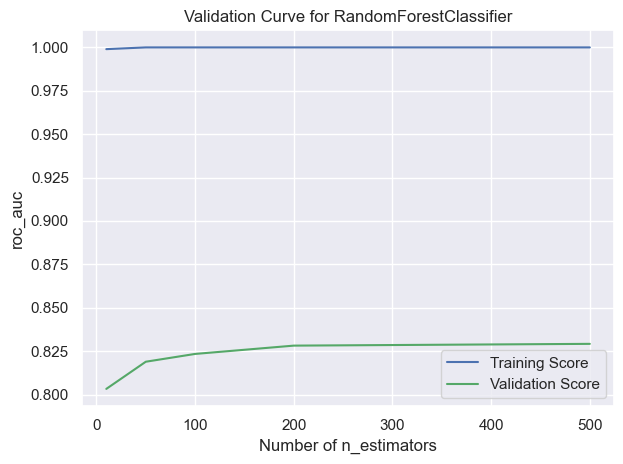

In [66]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]


rf_model = RandomForestClassifier(random_state=17)

for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])

In [67]:
rf_val_params[0][1]

[5, 8, 15, 20, 30, None]